# Problem X. The Wheel of data

Лашманов Валентин

In [216]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [217]:
%cd drive/MyDrive/kept/

[Errno 2] No such file or directory: 'drive/MyDrive/kept/'
/content/drive/MyDrive/kept


In [218]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [ ]:
#при открытии с utf-8 получаем ошибку
# df = pd.read_csv('cars.csv', sep = ';', encoding="utf-8")

In [219]:
dataframe = pd.read_csv('cars.csv', sep = ';', encoding="utf-16")  #при такой кодировке все нормально

In [220]:
dataframe.shape

(108536, 18)

### Обработка колонок таблицы

In [221]:
dataframe.head(3)

,brand,currency,description,model,price,url,year,Город,Коробка передач,Кузов,"Объем двигателя, л",Привод,Растаможен,Руль,Цвет,Пробег,Наличие,VIN
0,Mercedes-Benz,₸,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,https://kolesa.kz/a/show/10235750,2008,Актау,типтроник,внедорожник,5.5 (бензин),полный привод,Да,слева,черный металлик,NaN,NaN,NaN
1,BMW,₸,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,https://kolesa.kz/a/show/10269314,2009,Нур-Султан (Астана),автомат,кроссовер,4.8 (бензин),полный привод,Да,слева,черный,170 км,NaN,NaN
2,Mercedes-Benz,₸,"лонг, состояние нового авто немец газ-бензин п...",S 350,7770000,https://kolesa.kz/a/show/1063798,2006,Алматы,типтроник,седан,3.5 (бензин),NaN,Да,слева,черный,60 000 км,NaN,NaN


Описание некоторых колонок

`currency` - имеет только одно значение, поэтому это неинформативаня колонка <br>
`description` - текстовая колонка - ее нужно обрабатывать, например tf-idf <br>
`url` - колонка с уникальными значениями => неинформативная колонка <br>
`price` - таргет <br>
`brand`, `Город`, `Коробка передач`, `Кузов`, `Привод`, `Цвет` - категориальные переменные <br>
`Растаможен`, `Руль` - бинарные переменные


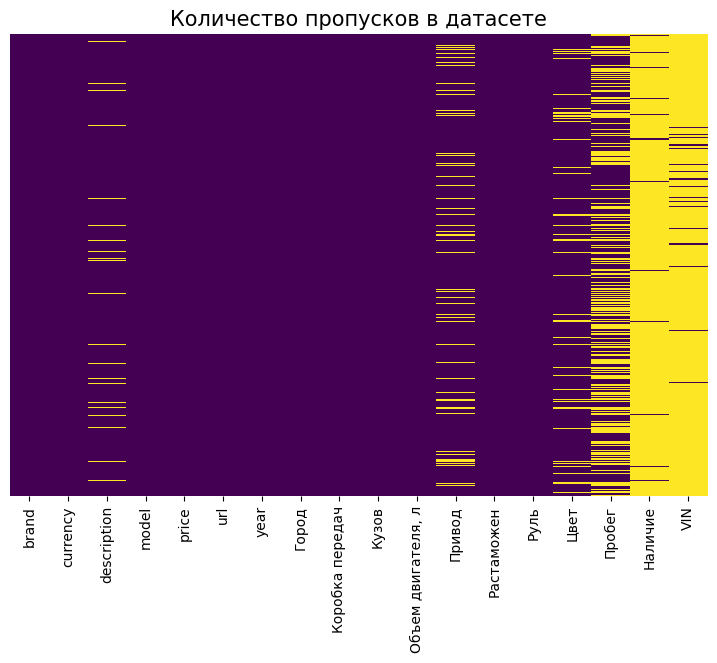

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set_title('Количество пропусков в датасете', fontsize=15)
sns_heatmap = sns.heatmap(dataframe.isnull(),
                          yticklabels=False,
                          cbar=False,
                          cmap='viridis')

Колонки `Наличие` и `VIN` практически полностью пустые => не включаем их в анализ

In [ ]:
print(dataframe['VIN'].isna().sum() / dataframe.shape[0]) #% пропусков в колонке VIN
print(dataframe['Наличие'].isna().sum() / dataframe.shape[0])    #% пропусков в колонке Наличие

0.9570465099137613
0.9616440627994398


In [222]:
def table_formatter(df):

  #обрабатываем колонку 'Объем двигателя, л'
  df['engine_cap_liters'] = df['Объем двигателя, л'].apply(lambda x: str(x).split(' ')[0]).astype(float)

  def second_element(row):
      if row is np.nan:
          return None
      else:
          return str(row).split(' ')[1]

  df['engine_type'] = df['Объем двигателя, л'].apply(second_element)
  df['engine_type'] = df['engine_type'].apply(lambda x: str(x).replace('(', '')).apply(lambda x: str(x).replace(')', ''))
  df.loc[df['engine_type'] == 'None', 'engine_type'] = np.nan
  df = df.drop(columns = 'Объем двигателя, л')

  # Растаможен, Руль
  df['Растаможен'] = df['Растаможен'].map({'Да' : 1, 'Нет' : 0})
  df['Руль'] = df['Руль'].map({'слева' : 1, 'справа' : 0})

  #обрабатываем колонку 'Пробег'
  df['Пробег'] = df['Пробег'].apply(lambda x: str(x).replace('км', '')).apply(lambda x: str(x).replace(' ', ''))
  df.loc[df['Пробег'] == 'nan', 'Пробег'] = np.nan
  df['Пробег'] = df['Пробег'].astype(float)   #теперь это просто число км

  df['log_price'] = np.log(df['price']) #добавляем логарифмированную цену

  df = df.drop(columns = ['currency', 'url', 'Наличие', 'VIN']) # удаляем неинформативные колонки

  df = df.drop_duplicates() # убираем дубликаты

  return df

In [223]:
df = table_formatter(dataframe)

## EDA

In [ ]:
df.head(3)

,brand,description,model,price,year,Город,Коробка передач,Кузов,Привод,Растаможен,Руль,Цвет,Пробег,engine_cap_liters,engine_type,log_price
0,Mercedes-Benz,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,2008,Актау,типтроник,внедорожник,полный привод,1,1.0,черный металлик,NaN,5.5,бензин,15.573368
1,BMW,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,2009,Нур-Султан (Астана),автомат,кроссовер,полный привод,1,1.0,черный,170.0,4.8,бензин,15.520259
2,Mercedes-Benz,"лонг, состояние нового авто немец газ-бензин п...",S 350,7770000,2006,Алматы,типтроник,седан,NaN,1,1.0,черный,60000.0,3.5,бензин,15.865781


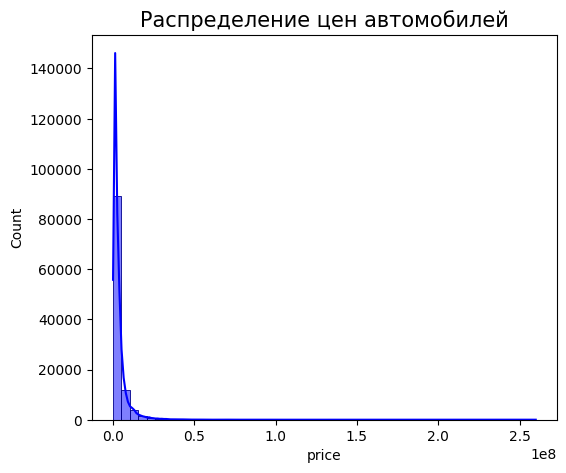

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_title('Распределение цен автомобилей', fontsize=15)
sns.histplot(df['price'],
             bins=50,
             ax=ax,
             color='blue',
             edgecolor='darkblue',
             kde = True);

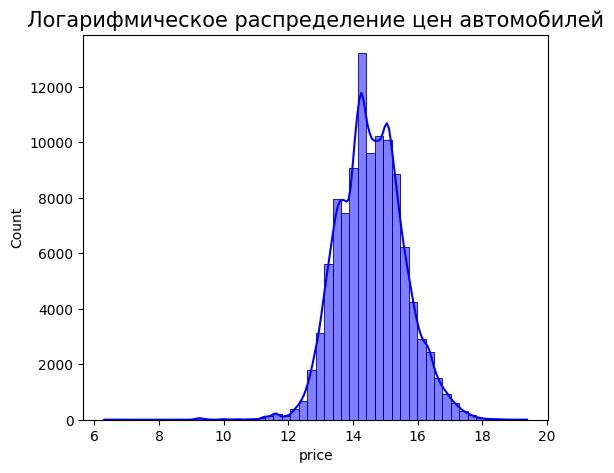

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_title('Логарифмическое распределение цен автомобилей', fontsize=15)
sns.histplot(np.log(df['price']),
             bins=50,
             ax=ax,
             color='blue',
             edgecolor='darkblue',
             kde = True);

Будем предсказывать логарифмическое распределение цен, тк оно похоже на нормальное. Модель будет предсказывать лучше, если целевая переменная распределена нормально.

In [ ]:
print('Наибольшее кол-во машин в ценовом интервале:', np.exp(13), '-',np.exp(17))
print('Среднее значение цены',df['price'].mean())

Наибольшее кол-во машин в ценовом интервале: 442413.3920089205 - 24154952.7535753
Среднее значение цены 3623569.747957033


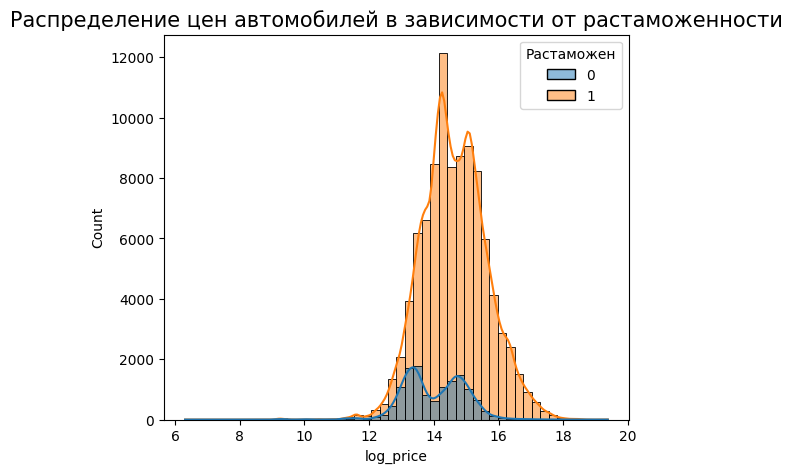

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_title('Распределение цен автомобилей в зависимости от растаможенности', fontsize=15)
sns.histplot(data=df,
             x='log_price',
             hue='Растаможен',
             bins=50,
             ax=ax,
             kde=True,);

Можем увидеть, что нерастаможенные машины могут стоить дешево, но их мало

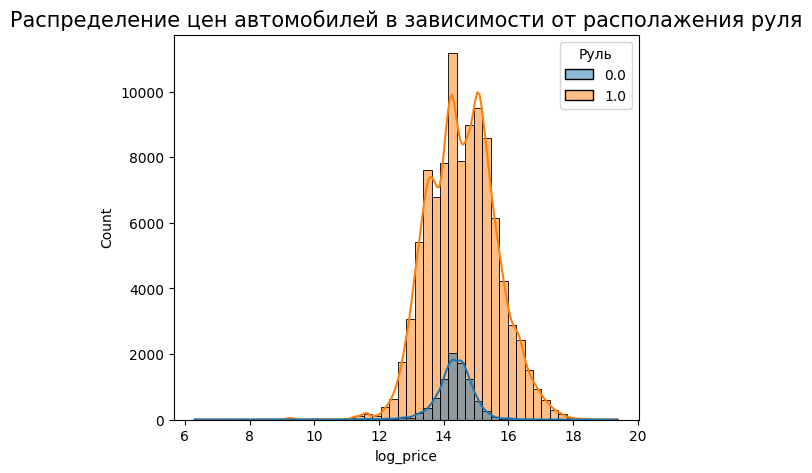

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_title('Распределение цен автомобилей в зависимости от располажения руля', fontsize=15)
sns.histplot(data=df,
             x='log_price',
             hue='Руль',
             bins=50,
             ax=ax,
             kde=True,);

In [ ]:
df_box = pd.DataFrame(df['brand'].value_counts()[:20]).reset_index()
df_box['index'].values
df_box_2 = df[df['brand'].isin(df_box['index'].values)]

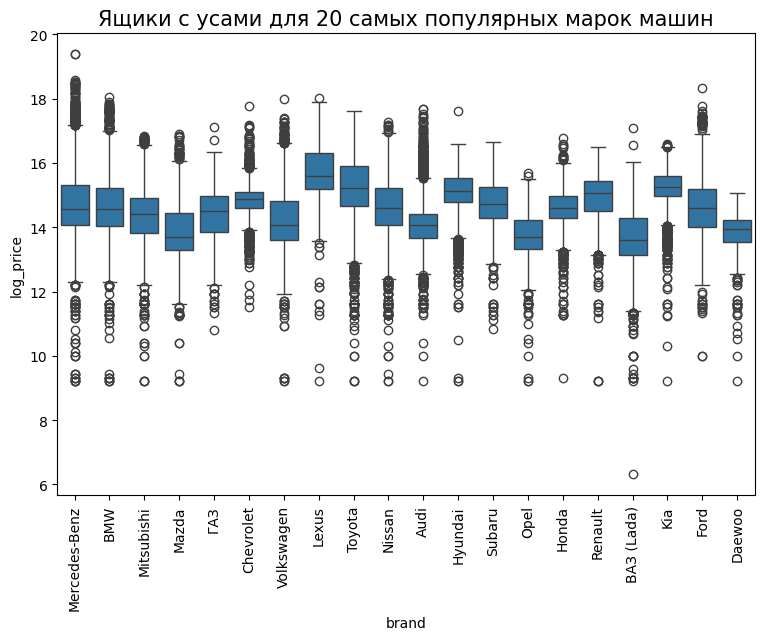

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
a=sns.boxplot(data=df_box_2, x='brand', y='log_price')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Ящики с усами для 20 самых популярных марок машин', fontsize=15);

Мы видим, что в данных очень много выбросов - как дешевых, так и очень дорогих машин => это говорит о том, что для регрессии лучше использовать метрику MAE - она менее чувствительна к выбросам

Сгенерируем новый признак - возраст машины

In [224]:
df['car_age'] = 2019 - df['year'] #сгенерируем новый признак - возраст машины

In [ ]:
avg_year_price_df = pd.DataFrame(df.groupby('car_age')['log_price'].mean()).reset_index()

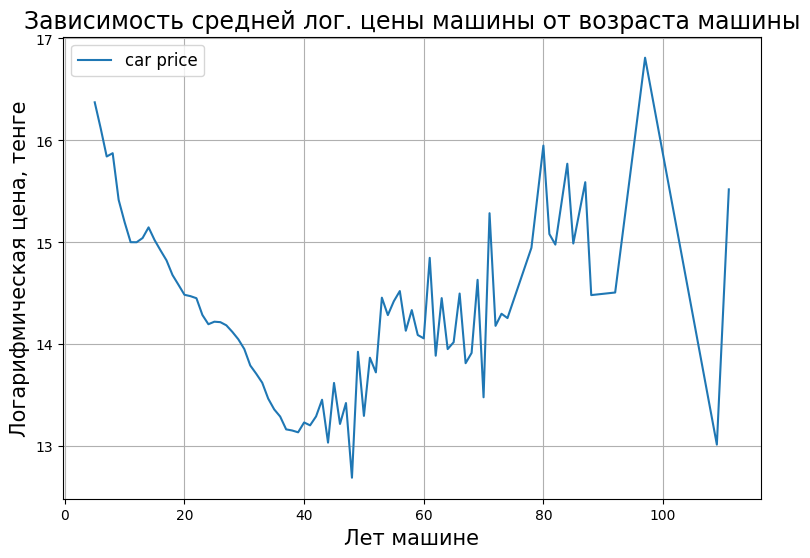

In [ ]:
plt.figure(figsize = (9, 6))
plt.plot(avg_year_price_df['car_age'], avg_year_price_df['log_price'],
         label='car price')
plt.title('Зависимость средней лог. цены машины от возраста машины', fontsize=17)
plt.xlabel('Лет машине', fontsize=15)
plt.ylabel('Логарифмическая цена, тенге', fontsize=15)
plt.legend(title='', title_fontsize=13, fontsize=12, ncol=2)
plt.grid()
plt.show()

Видим, что после 40 лет, стоимость машин начинает сильно колебаться. А до 40 лет - монотонно убывает

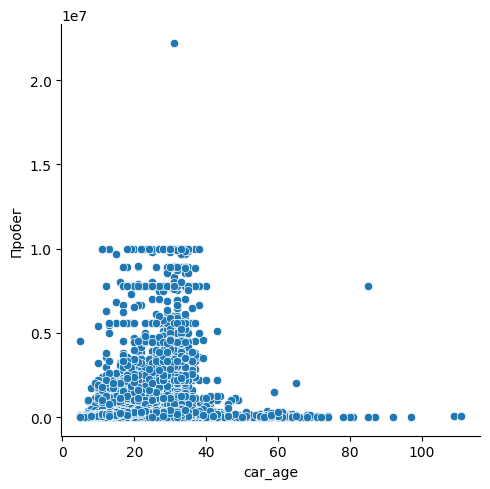

In [ ]:
sns.relplot(x='car_age',
            y='Пробег',
            data=df);

Можем заметить, что в основном, чем больше машине лет, тем больше у нее пробег, но далеко не всегда

Видим, что много старых машин с маленьким пробегом

<Axes: xlabel='car_age', ylabel='Count'>

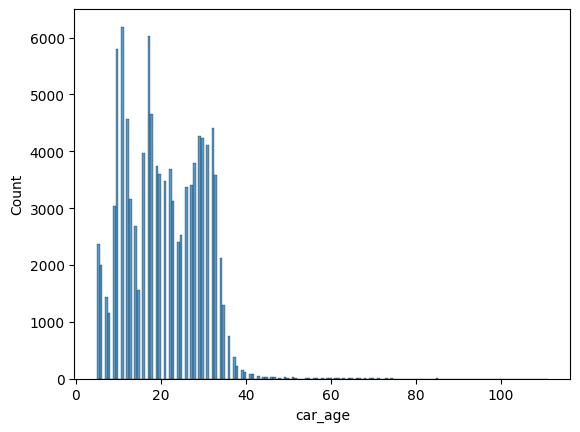

In [ ]:
sns.histplot(df['car_age'])

В датасете мало машин возрастом больше 40 лет

In [ ]:
df[df['car_age'] > 40]['price'].mean()

2529167.9782312927

In [ ]:
df[df['brand'] == 'Ретро-автомобили']['price'].mean()

4171852.2436363637

Большинство машин, которым 40 лет + - это ретро автомобили. Выделим их в отдельный ,бинарный признак

In [225]:
df['retro'] = 0
df.loc[df['car_age'] > 40, 'retro'] = 1

# Часть 1 - предсказание цены автомобиля

## Регрессии без текстовых данных Linear, Rigde, Lasso

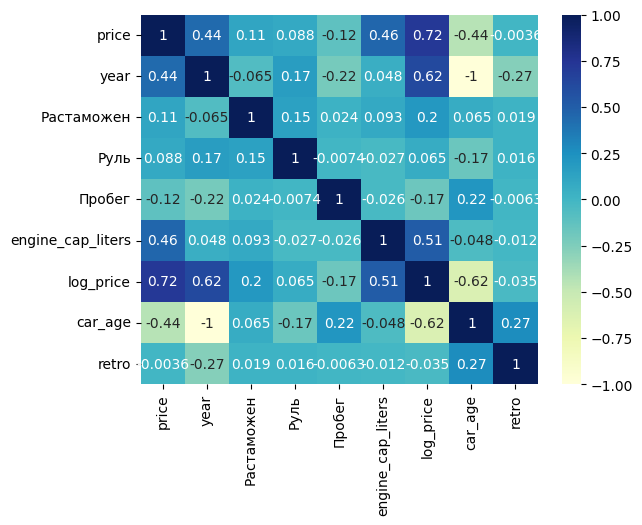

In [226]:
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [ ]:
def regressions_comparison(dataframe, regression_methods: list) -> pd.DataFrame:
  y = dataframe['log_price']
  x = dataframe.drop(columns=['price', 'log_price', 'description', 'year']) #год коррелирует с возрастом машины - удалим его

  #разделим выборку на валидационную, тестовую и трейновую
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)
  x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

  numeric_data = x_train.select_dtypes([np.number, np.int])
  numeric_data_mean = numeric_data.mean()
  numeric_features = numeric_data.columns

  #заполняем пропуски в категорниальных колонках
  categorical = list(x_train.dtypes[x_train.dtypes == "object"].index)
  x_train[categorical] = x_train[categorical].fillna("NotGiven")
  x_test[categorical] = x_test[categorical].fillna("NotGiven")
  x_valid[categorical] = x_valid[categorical].fillna("NotGiven")

  #заполняем пропуски в числовых колонках средним значением по колонке
  x_train = x_train.fillna(numeric_data_mean)
  x_test = x_test.fillna(numeric_data_mean)
  x_valid = x_valid.fillna(numeric_data_mean)

  output_df = pd.DataFrame(columns = ['Test RMSE', 'Train RMSE', 'Test MAE', 'Train MAE', 'Test R^2', 'Train R^2'])

  #константный прогноз
  best_constant = df["log_price"].mean()
  output_df.loc['Constant'] = [
                      mean_squared_error(y_test, best_constant * np.ones(y_test.shape), squared=False),
                      None,
                      mean_absolute_error(y_test, best_constant * np.ones(y_test.shape)),
                      None,
                      r2_score(y_test, best_constant * np.ones(y_test.shape)),
                      None ]


  column_transformer = ColumnTransformer([
     ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), categorical),
    ('scaling', StandardScaler(), numeric_features)])

  ralphas = np.logspace(-3, 3, 20)

  for num, reg_method in enumerate(regression_methods):

    pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', reg_method)])

    model = pipeline.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)

    output_df.loc[str(reg_method)] = [
                          mean_squared_error(y_test, y_pred, squared=False),
                          mean_squared_error(y_train, y_train_pred, squared=False),
                          mean_absolute_error(y_test, y_pred),
                          mean_absolute_error(y_train, y_train_pred),
                          r2_score(y_test, y_pred),
                          r2_score(y_train, y_train_pred)]

    if (str(reg_method) == 'Lasso()'):

      #перебираем параметр регуляризации для регрессии на neg_root_mean_squared_error

      pipeline = Pipeline(steps=[
            ('ohe_and_scaling', column_transformer),
            ('regression', Lasso())])

      rsearcher = GridSearchCV(pipeline, [{"regression__alpha": ralphas}],
                              scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
      rsearcher.fit(x_valid, y_valid)
      rbest_alpha = rsearcher.best_params_["regression__alpha"]

      pipeline = Pipeline(steps=[
            ('ohe_and_scaling', column_transformer),
            ('regression', Lasso(rbest_alpha))])

      model = pipeline.fit(x_train, y_train)
      y_pred = model.predict(x_test)
      y_train_pred = model.predict(x_train)

      output_df.loc['Lasso'' + GrSearch(MSE)'] = [
                            mean_squared_error(y_test, y_pred, squared=False),
                            mean_squared_error(y_train, y_train_pred, squared=False),
                            mean_absolute_error(y_test, y_pred),
                            mean_absolute_error(y_train, y_train_pred),
                            r2_score(y_test, y_pred),
                            r2_score(y_train, y_train_pred)]


      #перебираем параметр регуляризации для регрессии на neg_mean_absolute_error

      pipeline = Pipeline(steps=[
            ('ohe_and_scaling', column_transformer),
            ('regression', Lasso())])

      rsearcher = GridSearchCV(pipeline, [{"regression__alpha": ralphas}],
                              scoring="neg_mean_absolute_error", cv=10, n_jobs=-1)
      rsearcher.fit(x_valid, y_valid)
      rbest_alpha = rsearcher.best_params_["regression__alpha"]

      pipeline = Pipeline(steps=[
      ('ohe_and_scaling', column_transformer),
      ('regression', Lasso(rbest_alpha))])

      model = pipeline.fit(x_train, y_train)
      y_pred = model.predict(x_test)
      y_train_pred = model.predict(x_train)

      output_df.loc['Lasso'+' + GrSearch(MAE)'] = [
                            mean_squared_error(y_test, y_pred, squared=False),
                            mean_squared_error(y_train, y_train_pred, squared=False),
                            mean_absolute_error(y_test, y_pred),
                            mean_absolute_error(y_train, y_train_pred),
                            r2_score(y_test, y_pred),
                            r2_score(y_train, y_train_pred)]


    if (str(reg_method) == 'Ridge()'):

      #перебираем параметр регуляризации для регрессии на neg_root_mean_squared_error

      pipeline = Pipeline(steps=[
            ('ohe_and_scaling', column_transformer),
            ('regression', Ridge())])

      rsearcher = GridSearchCV(pipeline, [{"regression__alpha": ralphas}],
                              scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
      rsearcher.fit(x_valid, y_valid)
      rbest_alpha = rsearcher.best_params_["regression__alpha"]

      pipeline = Pipeline(steps=[
            ('ohe_and_scaling', column_transformer),
            ('regression', Ridge(rbest_alpha))])

      model = pipeline.fit(x_train, y_train)
      y_pred = model.predict(x_test)
      y_train_pred = model.predict(x_train)

      output_df.loc['Ridge'' + GrSearch(MSE)'] = [
                            mean_squared_error(y_test, y_pred, squared=False),
                            mean_squared_error(y_train, y_train_pred, squared=False),
                            mean_absolute_error(y_test, y_pred),
                            mean_absolute_error(y_train, y_train_pred),
                            r2_score(y_test, y_pred),
                            r2_score(y_train, y_train_pred)]


      #перебираем параметр регуляризации для регрессии на neg_mean_absolute_error

      pipeline = Pipeline(steps=[
            ('ohe_and_scaling', column_transformer),
            ('regression', Ridge())])

      rsearcher = GridSearchCV(pipeline, [{"regression__alpha": ralphas}],
                              scoring="neg_mean_absolute_error", cv=10, n_jobs=-1)
      rsearcher.fit(x_valid, y_valid)
      rbest_alpha = rsearcher.best_params_["regression__alpha"]

      pipeline = Pipeline(steps=[
      ('ohe_and_scaling', column_transformer),
      ('regression', Ridge(rbest_alpha))])

      model = pipeline.fit(x_train, y_train)
      y_pred = model.predict(x_test)
      y_train_pred = model.predict(x_train)

      output_df.loc['Ridge'+' + GrSearch(MAE)'] = [
                            mean_squared_error(y_test, y_pred, squared=False),
                            mean_squared_error(y_train, y_train_pred, squared=False),
                            mean_absolute_error(y_test, y_pred),
                            mean_absolute_error(y_train, y_train_pred),
                            r2_score(y_test, y_pred),
                            r2_score(y_train, y_train_pred)]

  return output_df

In [ ]:
regression_methods = [LinearRegression(), Ridge(), Lasso()]
res_df = regressions_comparison(df, regression_methods = regression_methods)

In [ ]:
res_df

,Test RMSE,Train RMSE,Test MAE,Train MAE,Test R^2,Train R^2
Constant,1.015262,NaN,0.809836,NaN,-0.000153,NaN
LinearRegression(),0.380829,0.360747,0.222693,0.214502,0.859275,0.874655
Ridge(),0.376899,0.362634,0.221921,0.216349,0.862164,0.873341
Ridge + GrSearch(MSE),0.376709,0.363382,0.222015,0.216890,0.862304,0.872818
Ridge + GrSearch(MAE),0.376709,0.363382,0.222015,0.216890,0.862304,0.872818
Lasso(),1.015288,1.018944,0.809811,0.809788,-0.000204,0.000000
Lasso + GrSearch(MSE),0.421224,0.423246,0.263112,0.266644,0.827838,0.827462
Lasso + GrSearch(MAE),0.421224,0.423246,0.263112,0.266644,0.827838,0.827462


Видим, что учше всего работает Ridge с регуляризацией относительно MAE (MAE лучше, чем RMSE? тк модель менее чувствительна к выбросам)

In [213]:
# np.exp(0.222015)

In [214]:
# np.exp(0.376709)

Стоит сказать, что то что мы предсказываем логарифмическую цену машины, а потому не можем сказать, что наша модель ошибается в среднем на $e^{0.222}= 1.24$ тенге (не можем так интерпретировать).

## Бустинг без текстовых данных

In [230]:
# !pip install catboost
# !pip install shap
# !pip install optuna

In [229]:
from catboost import Pool, CatBoostRegressor, cv
import shap
import optuna

In [231]:
df['Руль'] = df['Руль'].fillna(2)

In [232]:
y = df['log_price']
x = df.drop(columns=['price', 'log_price', 'description', 'year'])  # год уберем - он коррелирует с возрастом машины
x['Руль'] = x['Руль'].astype(int)

#разделим выборку на валидационную, тестовую и трейновую
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)
x_train.shape, x_valid.shape, x_test.shape

((86540, 14), (10818, 14), (10818, 14))

In [233]:
categorical_features_indices = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 13])  #категориальные колонки

In [234]:
x_train.iloc[:, categorical_features_indices].columns

Index(['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro'],
      dtype='object')

In [235]:
numeric_means = x_train[['Пробег', 'engine_cap_liters', 'car_age']].mean()
x_train[['Пробег', 'engine_cap_liters', 'car_age']] = x_train[['Пробег', 'engine_cap_liters', 'car_age']].fillna(numeric_means)
x_test[['Пробег', 'engine_cap_liters', 'car_age']] = x_test[['Пробег', 'engine_cap_liters', 'car_age']].fillna(numeric_means)
x_valid[['Пробег', 'engine_cap_liters', 'car_age']] = x_valid[['Пробег', 'engine_cap_liters', 'car_age']].fillna(numeric_means)

In [236]:
x_train[['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro']] = x_train[['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro']].fillna('NONE')

x_test[['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro']] = x_test[['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro']].fillna('NONE')

x_valid[['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro']] = x_valid[['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro']].fillna('NONE')

Обучим бустинг на RMSE функции потерь

In [237]:
base_model = CatBoostRegressor(
    iterations = 1000,
    random_seed=42,
    verbose=1,

    loss_function = 'RMSE',
    eval_metric = 'RMSE',
    early_stopping_rounds= 15,
)

In [ ]:
base_model.fit(
    x_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(x_valid, y_valid),
    # logging_level='Verbose',  # you can uncomment this for text output
);

Learning rate set to 0.102574
0:	learn: 0.9463628	test: 0.9459960	best: 0.9459960 (0)	total: 173ms	remaining: 2m 52s
1:	learn: 0.8836120	test: 0.8826183	best: 0.8826183 (1)	total: 310ms	remaining: 2m 34s
2:	learn: 0.8261421	test: 0.8245846	best: 0.8245846 (2)	total: 483ms	remaining: 2m 40s
3:	learn: 0.7770592	test: 0.7749700	best: 0.7749700 (3)	total: 649ms	remaining: 2m 41s
4:	learn: 0.7345663	test: 0.7321802	best: 0.7321802 (4)	total: 744ms	remaining: 2m 27s
5:	learn: 0.6952979	test: 0.6920960	best: 0.6920960 (5)	total: 876ms	remaining: 2m 25s
6:	learn: 0.6609685	test: 0.6570397	best: 0.6570397 (6)	total: 1.03s	remaining: 2m 26s
7:	learn: 0.6311696	test: 0.6265556	best: 0.6265556 (7)	total: 1.17s	remaining: 2m 25s
8:	learn: 0.6058301	test: 0.6007762	best: 0.6007762 (8)	total: 1.36s	remaining: 2m 29s
9:	learn: 0.5800837	test: 0.5746737	best: 0.5746737 (9)	total: 1.49s	remaining: 2m 27s
10:	learn: 0.5582401	test: 0.5524678	best: 0.5524678 (10)	total: 1.62s	remaining: 2m 25s
11:	learn: 

In [ ]:
base_model.best_score_

{'learn': {'RMSE': 0.3254766178609304},
 'validation': {'RMSE': 0.33586216626905896}}

In [ ]:
feat_importances = base_model.get_feature_importance(prettified=True)
feat_importances

,Feature Id,Importances
0,car_age,37.571680
1,engine_cap_liters,16.134246
2,brand,12.750139
3,Коробка передач,8.939867
4,model,8.475942
5,Кузов,4.036387
6,Растаможен,3.686726
7,Привод,2.418308
8,Пробег,1.591640
9,Город,1.510936


In [ ]:
preds = base_model.predict(x_test)
mean_squared_error(y_test, preds, squared=False)  #ошибка на тесте

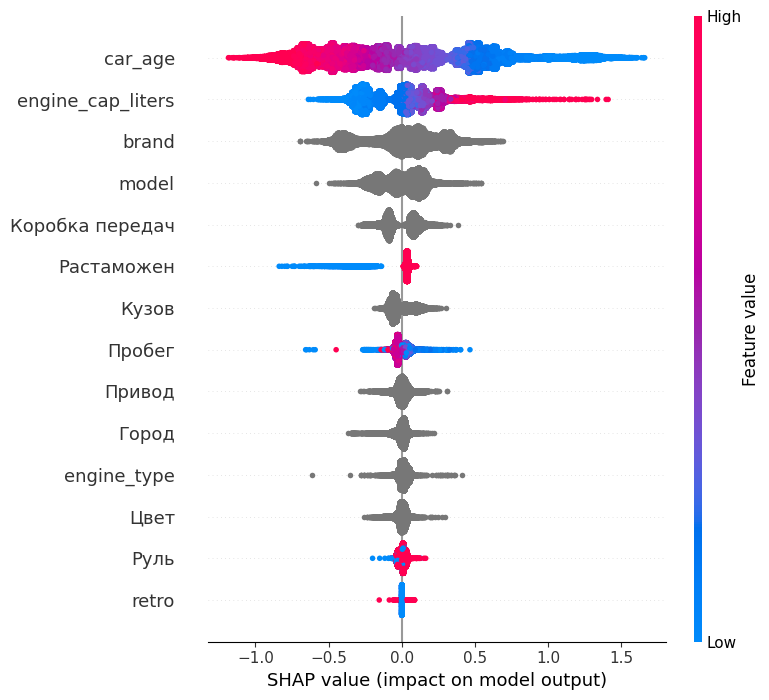

In [ ]:
explainer = shap.TreeExplainer(base_model)
shap_values = explainer(x_train)
shap.summary_plot(shap_values, x_train)

Анализ shap values нам показывает, что самыми значимыми переменными для модели являются возраст машины и объем двигателя.

Интерпретация такая: <br>
- Чем меньше возраст машине, тем в среднем дороже она стоит и наоборот. <br>
- Чем больше объем двигателя машины - тем дороже в среднем она стоит. <br>
- Если машина не растоможена, она стоит дешевле, чем растаможенная машина. <br>
- Чем меньше показатель пробега - тем дороже стоит машина.

Обучим бустинг на MAE функции потерь

In [238]:
mae_model = CatBoostRegressor(
    iterations = 1000, #по дефолту 1000 деревьев в ансамбле
    random_seed=42,
    verbose=1,   #0 - ничего не пиши
    loss_function = 'MAE',
    eval_metric = 'MAE',
    early_stopping_rounds= 15, #сколько эпох учиться
)

mae_model.fit(
    x_train, y_train,
    cat_features=categorical_features_indices,  #cat boost делает для категориальных фичей target encoding (вставляем индексы из таблицы)
    eval_set=(x_valid, y_valid),      # используем для валидации
    # logging_level='Verbose',  # you can uncomment this for text output
);

0:	learn: 0.7905412	test: 0.7915198	best: 0.7915198 (0)	total: 407ms	remaining: 6m 46s
1:	learn: 0.7723325	test: 0.7733693	best: 0.7733693 (1)	total: 700ms	remaining: 5m 49s
2:	learn: 0.7545691	test: 0.7556719	best: 0.7556719 (2)	total: 1.01s	remaining: 5m 34s
3:	learn: 0.7375877	test: 0.7387356	best: 0.7387356 (3)	total: 1.28s	remaining: 5m 19s
4:	learn: 0.7214887	test: 0.7226123	best: 0.7226123 (4)	total: 1.52s	remaining: 5m 1s
5:	learn: 0.7059578	test: 0.7071926	best: 0.7071926 (5)	total: 1.75s	remaining: 4m 50s
6:	learn: 0.6906852	test: 0.6919534	best: 0.6919534 (6)	total: 2.02s	remaining: 4m 46s
7:	learn: 0.6760858	test: 0.6773238	best: 0.6773238 (7)	total: 2.23s	remaining: 4m 36s
8:	learn: 0.6620008	test: 0.6632527	best: 0.6632527 (8)	total: 2.37s	remaining: 4m 20s
9:	learn: 0.6483689	test: 0.6495320	best: 0.6495320 (9)	total: 2.54s	remaining: 4m 11s
10:	learn: 0.6352880	test: 0.6363760	best: 0.6363760 (10)	total: 2.75s	remaining: 4m 7s
11:	learn: 0.6229886	test: 0.6239597	best: 

In [239]:
preds = mae_model.predict(x_test)
mean_absolute_error(y_test, preds)  #ошибка на тесте

0.20819691629330409

Видим, что ошибка на тестовой выборке меньше, чем у Ridge регрессии

In [ ]:
feat_importances = mae_model.get_feature_importance(prettified=True)
feat_importances

,Feature Id,Importances
0,car_age,41.439515
1,engine_cap_liters,15.839991
2,brand,14.681311
3,model,9.448964
4,Коробка передач,7.040680
5,Кузов,4.035889
6,Растаможен,3.322888
7,Руль,0.993288
8,Привод,0.889262
9,Пробег,0.889227


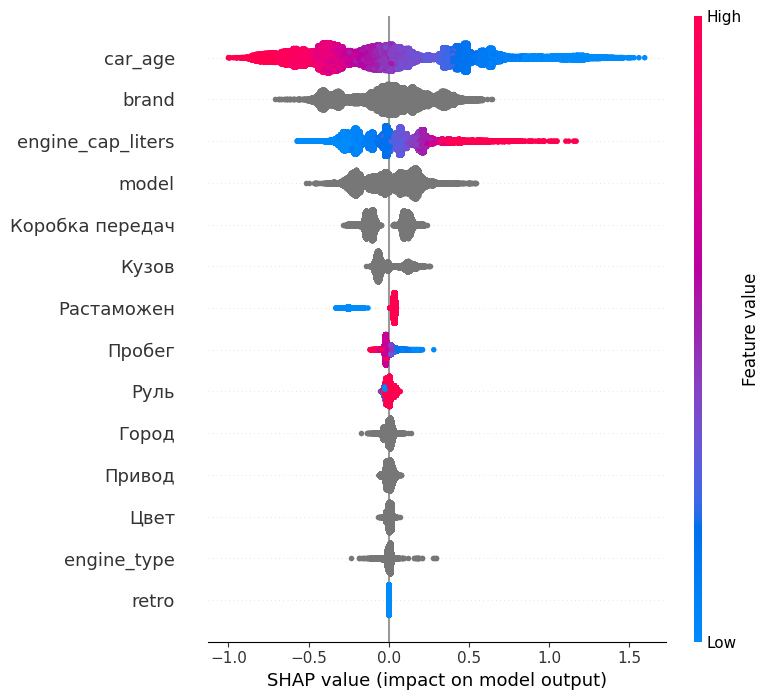

In [ ]:
explainer = shap.TreeExplainer(mae_model)
shap_values = explainer(x_train)
shap.summary_plot(shap_values, x_train)

Для модели обученной на MAE помимо возраста машины стал больше играть значение бренд.
Модель, обученная на MAE точнее предсказывает цену машины.

Не думаю, что есть смысл делать перебор гиперпараметров, модель и так предсказывает цену машины с точностью до 2 тенге

## Добавляем текстовые данные в бустинг

Надо сделать как тут:
https://www.kaggle.com/code/prashantsaraswat88/using-text-based-features-for-price-regression#Cleaning-the-data

In [ ]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
tqdm.pandas()

mystem = Mystem()
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]

    text = " ".join(tokens)
    return text

In [ ]:
data = df[['brand', 'model', 'description']]

In [ ]:
data['description'] = data['description'].progress_apply(lambda x: preprocess_text(str(x)))

100%|██████████| 108536/108536 [05:30<00:00, 327.91it/s]
<ipython-input-23-a3f09ca0d178>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['description'] = data['description'].progress_apply(lambda x: preprocess_text(str(x)))


In [ ]:
data['description'] = data['description'].progress_apply(lambda x: x.replace('qt', '').replace('lt', '').replace('quot', '').replace('gt', '').replace('p', '').replace('br', '').replace('li', ''))

100%|██████████| 108536/108536 [00:01<00:00, 78288.44it/s]


In [ ]:
df['description'][7]  #до

'фаркоп ,  велюр ,  налог уплачен, техосмотр пройден  Требуется вложение, Продам не большой торг, или варианты обмена c доплатой классом выше'

In [ ]:
data['description'][7] #после обработки

'фаркоп велюр налог уплачивать техосмотр проходить требоваться вложение продавать большой торг вариант обмен c доплата класс выше'

In [ ]:
data.to_excel('preprocess_descr.xlsx', index=False)

In [ ]:
data = pd.read_excel('preprocess_descr.xlsx')

In [ ]:
data = data.fillna('NONE')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=300) # min_df is the minimum number of times a word needs to appear in the corpus in order to be assigned
tfidf.fit(data['description'])

TfidfVectorizer(min_df=300)

Если добавим к датафрейму текстовые признаки - получим еще 928 фичей

In [ ]:
len(tfidf.vocabulary_)

928

Визуализируем самые часто встречающиеся слова в описании машин

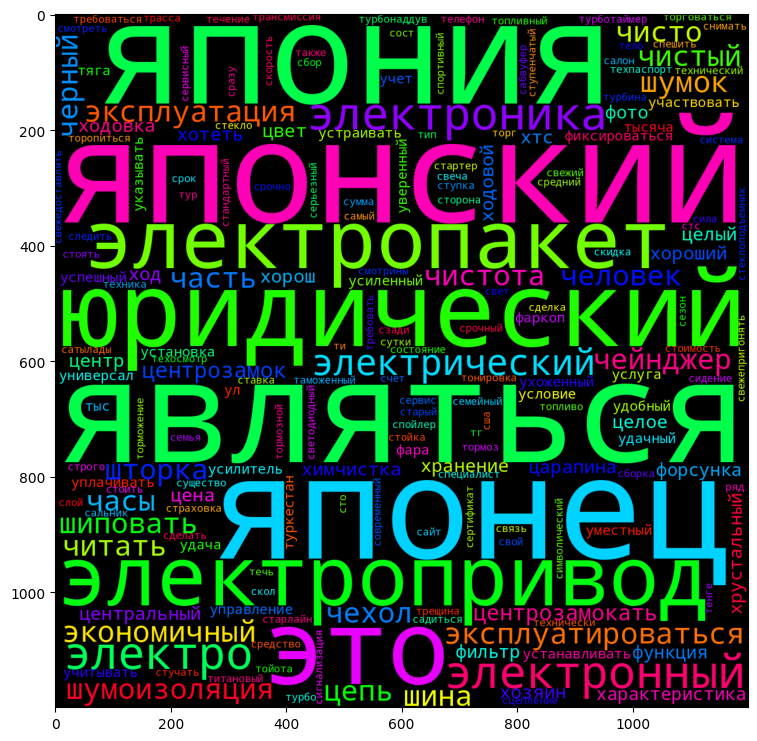

In [ ]:
from wordcloud import WordCloud

word_could_dict = tfidf.vocabulary_

wordcloud = WordCloud(width = 1200, height = 1200, colormap = 'hsv_r').generate_from_frequencies(word_could_dict)

plt.figure(figsize=(12,9))
plt.imshow(wordcloud);

In [ ]:
word_df = pd.DataFrame(word_could_dict.items()).rename(columns={0:'word', 1:'count'}).sort_values(by='count', ascending=False)

In [ ]:
word_df[:20]

,word,count
733,японский,927
417,япония,926
614,японец,925
301,являться,924
741,юридический,923
217,это,922
384,электропривод,921
1,электропакет,920
500,электронный,919
838,электроника,918


In [ ]:
tfidf = TfidfVectorizer(min_df=300) # min_df is the minimum number of times a word needs to appear in the corpus in order to be assigned
df1 = tfidf.fit_transform(data['description'])

In [ ]:
df1 = pd.DataFrame(df1.toarray(), columns=tfidf.get_feature_names_out())

In [ ]:
df1.head(3)

,00,000,10,100,100км,11,12,13,14,15,...,электроника,электронный,электропакет,электропривод,это,юридический,являться,японец,япония,японский
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.311317,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.067403,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = pd.concat([df, df1], axis=1)
df = df.drop(columns = 'description')
df = df[~df['brand'].isna()]

In [ ]:
df.to_excel('full_dataset.xlsx', index=False)

In [ ]:
df.head(5)

,brand,model,price,year,Город,Коробка передач,Кузов,Привод,Растаможен,Руль,...,электроника,электронный,электропакет,электропривод,это,юридический,являться,японец,япония,японский
0,Mercedes-Benz,GL 550,5800000.0,2008.0,Актау,типтроник,внедорожник,полный привод,1.0,1.0,...,0.0,0.0,0.311317,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BMW,X5,5500000.0,2009.0,Нур-Султан (Астана),автомат,кроссовер,полный привод,1.0,1.0,...,0.0,0.0,0.067403,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Mercedes-Benz,S 350,7770000.0,2006.0,Алматы,типтроник,седан,NaN,1.0,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mitsubishi,Outlander,3200000.0,2003.0,Семей,типтроник,кроссовер,полный привод,1.0,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ретро-автомобили,"ГАЗ 21 ""Волга""",3900000.0,1970.0,Алматы,механика,седан,задний привод,1.0,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Обрабатываем новые колонки для бустинга

In [ ]:
y = df['log_price']
x = df.drop(columns=['price', 'log_price', 'year'])  # год уберем - он коррелирует с возрастом машины
x['Руль'] = x['Руль'].astype(int)

#разделим выборку на валидационную, тестовую и трейновую
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)
x_train.shape, x_valid.shape, x_test.shape

((86540, 942), (10818, 942), (10818, 942))

In [ ]:
x_train[x_train.columns[:20]]

,brand,model,Город,Коробка передач,Кузов,Привод,Растаможен,Руль,Цвет,Пробег,engine_cap_liters,engine_type,car_age,retro,00,000,10,100,100км,11
65310,Nissan,Murano,Атырау,автомат,кроссовер,полный привод,1.0,1,серый металлик,NaN,3.0,газ-бензин,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85674,Hyundai,Solaris,Шымкент,типтроник,седан,передний привод,1.0,1,белый,17500.0,1.6,бензин,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44982,Daewoo,Nexia,Алматы,механика,седан,передний привод,1.0,1,бордовый металлик,173000.0,1.5,бензин,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32577,Opel,Vectra,Алматы,автомат,хэтчбек/лифтбек,передний привод,1.0,1,черный металлик,255000.0,2.2,бензин,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28268,Opel,Vectra,Шымкент,механика,седан,передний привод,1.0,1,вишня,487000.0,1.8,бензин,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85373,ВАЗ (Lada),2114 (хэтчбек),Шымкент,механика,хэтчбек/лифтбек,передний привод,1.0,1,коричневый,80000.0,1.6,бензин,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9471,Kia,Rio,Актобе,автомат,хэтчбек/лифтбек,передний привод,1.0,1,белый,15000.0,1.4,бензин,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99464,Toyota,Avensis,Нур-Султан (Астана),механика,хэтчбек/лифтбек,передний привод,1.0,1,зеленый металлик,290000.0,2.0,бензин,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57630,Mazda,323,Шымкент,механика,седан,передний привод,1.0,1,синий,123456.0,1.5,газ-бензин,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
categorical_features_indices = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 13])  #категориальные колонки

In [ ]:
x_train.iloc[:, categorical_features_indices].columns

Index(['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro'],
      dtype='object')

In [ ]:
x_train['retro'] = x_train['retro'].astype(int)
x_train['Растаможен'] = x_train['Растаможен'].astype(int)

x_test['retro'] = x_test['retro'].astype(int)
x_test['Растаможен'] = x_test['Растаможен'].astype(int)

x_valid['retro'] = x_valid['retro'].astype(int)
x_valid['Растаможен'] = x_valid['Растаможен'].astype(int)

In [ ]:
numeric_means = x_train[['Пробег', 'engine_cap_liters', 'car_age']].mean()
x_train[['Пробег', 'engine_cap_liters', 'car_age']] = x_train[['Пробег', 'engine_cap_liters', 'car_age']].fillna(numeric_means)
x_test[['Пробег', 'engine_cap_liters', 'car_age']] = x_test[['Пробег', 'engine_cap_liters', 'car_age']].fillna(numeric_means)
x_valid[['Пробег', 'engine_cap_liters', 'car_age']] = x_valid[['Пробег', 'engine_cap_liters', 'car_age']].fillna(numeric_means)

In [ ]:
x_train[['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro']] = x_train[['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro']].fillna('NONE')

x_test[['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro']] = x_test[['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro']].fillna('NONE')

x_valid[['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro']] = x_valid[['brand', 'model', 'Город', 'Коробка передач', 'Кузов', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'engine_type', 'retro']].fillna('NONE')

In [ ]:
mae_model = CatBoostRegressor(
    iterations = 1000, #по дефолту 1000 деревьев в ансамбле
    random_seed=42,
    verbose=1,   #0 - ничего не пиши
    loss_function = 'MAE',
    eval_metric = 'MAE',
    early_stopping_rounds= 15, #сколько эпох учиться
)

mae_model.fit(
    x_train, y_train,
    cat_features=categorical_features_indices,  #cat boost делает для категориальных фичей target encoding (вставляем индексы из таблицы)
    eval_set=(x_valid, y_valid),      # используем для валидации
    # logging_level='Verbose',  # you can uncomment this for text output
);

0:	learn: 0.7902906	test: 0.7913447	best: 0.7913447 (0)	total: 1.35s	remaining: 22m 32s
1:	learn: 0.7724889	test: 0.7735245	best: 0.7735245 (1)	total: 2.36s	remaining: 19m 38s
2:	learn: 0.7547591	test: 0.7559104	best: 0.7559104 (2)	total: 2.94s	remaining: 16m 17s
3:	learn: 0.7383991	test: 0.7395779	best: 0.7395779 (3)	total: 3.57s	remaining: 14m 49s
4:	learn: 0.7221942	test: 0.7234639	best: 0.7234639 (4)	total: 4.14s	remaining: 13m 45s
5:	learn: 0.7066440	test: 0.7079511	best: 0.7079511 (5)	total: 4.96s	remaining: 13m 42s
6:	learn: 0.6913836	test: 0.6927376	best: 0.6927376 (6)	total: 5.64s	remaining: 13m 20s
7:	learn: 0.6770822	test: 0.6785702	best: 0.6785702 (7)	total: 6.21s	remaining: 12m 50s
8:	learn: 0.6631293	test: 0.6646978	best: 0.6646978 (8)	total: 6.91s	remaining: 12m 40s
9:	learn: 0.6495290	test: 0.6509882	best: 0.6509882 (9)	total: 7.61s	remaining: 12m 33s
10:	learn: 0.6364970	test: 0.6378431	best: 0.6378431 (10)	total: 8.46s	remaining: 12m 40s
11:	learn: 0.6238517	test: 0.6

In [ ]:
preds = mae_model.predict(x_test)
mean_absolute_error(y_test, preds)  #ошибка на тесте

0.20479243128236188

Ошибка немного уменьшилась - было 0.208

In [ ]:
feat_importances = mae_model.get_feature_importance(prettified=True)
feat_importances

,Feature Id,Importances
0,car_age,39.675683
1,engine_cap_liters,14.203493
2,brand,12.819489
3,model,9.546568
4,Коробка передач,6.205700
...,...,...
937,электронный,0.000000
938,это,0.000000
939,юридический,0.000000
940,являться,0.000000


Однако важность возраста машины еще сильнее увеличилась для модели

In [ ]:
# explainer = shap.TreeExplainer(mae_model)
# shap_values = explainer(x_train)
# shap.summary_plot(shap_values, x_train)

## А если использовать PCA? (не успел)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=0.9).fit_transform(train_df)

In [ ]:
y = df['log_price']
x = df.drop(columns=['price', 'log_price', 'year'])

In [ ]:
#разделим выборку на валидационную, тестовую и трейновую
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

In [ ]:
numeric_data = x_train.select_dtypes([np.number, np.int])
categorical = list(x_train.dtypes[x_train.dtypes == "object"].index)

In [ ]:
numeric_features = numeric_data.columns

numeric_means = x_train[['Пробег', 'engine_cap_liters', 'car_age']].mean()
x_train[['Пробег', 'engine_cap_liters', 'car_age']] = x_train[['Пробег', 'engine_cap_liters', 'car_age']].fillna(numeric_means)
x_test[['Пробег', 'engine_cap_liters', 'car_age']] = x_test[['Пробег', 'engine_cap_liters', 'car_age']].fillna(numeric_means)
x_valid[['Пробег', 'engine_cap_liters', 'car_age']] = x_valid[['Пробег', 'engine_cap_liters', 'car_age']].fillna(numeric_means)

# x_train[categorical] = x_test[categorical].fillna("NotGiven")
# x_test[categorical] = x_test[categorical].fillna("NotGiven")
# x_valid[categorical] = x_valid[categorical].fillna("NotGiven")

In [ ]:
column_transformer = ColumnTransformer([
     ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), categorical),
    ('scaling', StandardScaler(), numeric_features)])

In [ ]:
pipeline = Pipeline(steps=[
      ('ohe_and_scaling', column_transformer)])

In [ ]:
x_train = pipeline.fit_transform(x_train)

In [124]:
df['year'].max()

2019

# Часть 2 - обесценение машин со временем

In [125]:
df['avg_odometer_per_age'] = df['Пробег'] / df['car_age'] #переменная, которую следовало бы создать раньше, но из-за того, что в ней много пропусков - она проблемная

In [126]:
df1 = df.drop(columns = ['description', 'year'])

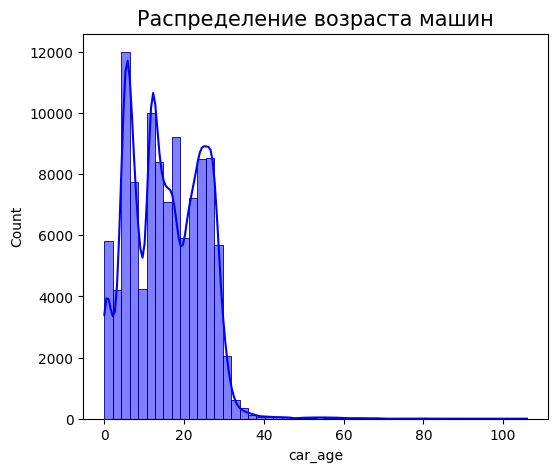

In [127]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_title('Распределение возраста машин', fontsize=15)
sns.histplot(df1['car_age'],
             bins=50,
             ax=ax,
             color='blue',
             edgecolor='darkblue',
             kde = True);

Побъем возраст машины на bins до 40 лет, потому что после 40 лет - это уже раритетные машин (их цена скорее уже зависит не от характеристик, а от редкости и прочего).

Эти bins и будут нашими ценовыми кластерами

In [128]:
df1 = df1[df1['car_age'] < 40]

In [19]:
from sklearn.preprocessing import KBinsDiscretizer

In [129]:
est = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform', subsample=None)

In [130]:
est.fit(df1[['car_age']])

KBinsDiscretizer(encode='ordinal', n_bins=8, strategy='uniform', subsample=None)

In [131]:
bins = est.transform(df1[['car_age']])

In [132]:
df1['bin'] = bins

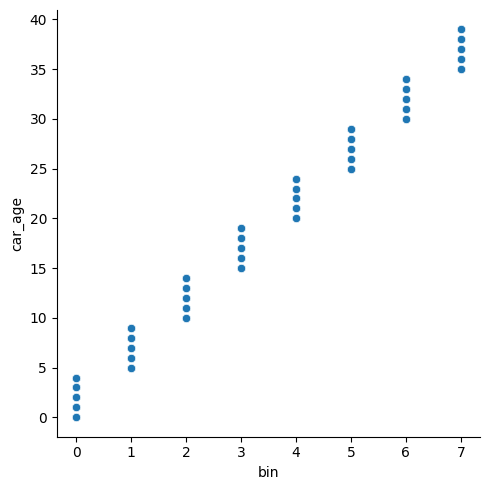

In [133]:
sns.relplot(x='bin',  # визуализация bin-ов
            y='car_age',
            data=df1);

Сделаем функцию, которая выводит график зависимости средней цены машины для конкретного бренда в зависимости от возраста машины внутри пятилеток.

In [208]:
def check_value_deprecatin_by_brands(df, brand_names: list):
  plt.figure(figsize = (12, 8))
  for brand_name in brand_names:
    brand_filter = (df['brand'] == brand_name)
    df2 = df[brand_filter]
    df2 = df2.groupby(['bin'])['price'].mean().reset_index()

    plt.plot(df2['bin'], df2['price'], marker='o', label=f'{brand_name}')
    plt.xlabel('Пятилетний промежуток', fontsize=13)
    plt.ylabel('Средняя цена машины, тенге', fontsize=13)
  plt.title(f'Зависимость средней цены машины внутри пятилетнего периода от бренда', fontsize=14)
  plt.legend(
           fontsize=10,
           loc='upper right',
           shadow=True)
  plt.xticks(np.arange(8),
           labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40'],
           fontsize=9)
  plt.grid()
  plt.show()

Возмьем топ 10 самых встречающихся марок машин в датасете и посмотрим на их обесценивание с течением времени

In [209]:
top10_most_frequent_car_brands = pd.DataFrame(df1['brand'].value_counts()[:10]).reset_index()['index'].values

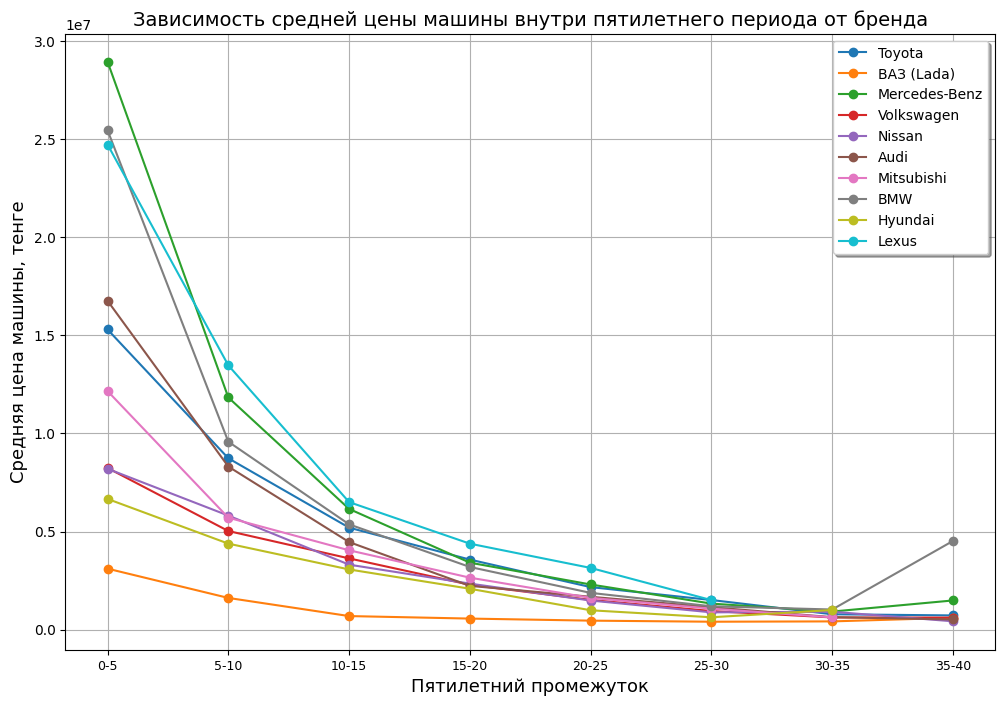

In [210]:
check_value_deprecatin_by_brands(df1, top10_most_frequent_car_brands)

Мы видим, что средняя цена машины снижается в среднем больше чем в 2 раза в первые 5 лет жизни машины, а дальше монотонно убывает. Чем дороже изначально стоит машина, тем больше она теряет в стоимости в первые 5 лет в абсолютном значении.

Однако после 35-летнего промежутка жизни машины - некоторые марки машин (например BMW) видимо переходят в категорию раритетов, и их цена начинает расти.

Тепрерь построим такой же график для конкретных моделей машин

In [211]:
def check_value_deprecatin_by_brand_and_models(df, car_dict: dict):
  plt.figure(figsize = (12, 8))
  for brand, models in car_dict.items():
    for model in models:
      brand_filter = ((df['brand'] == brand) & (df['model'] == model))
      df2 = df[brand_filter]
      df2 = df2.groupby(['bin'])['price'].mean().reset_index()

      plt.plot(df2['bin'], df2['price'], marker='o', label=f'{brand} {model}')

  plt.xlabel('Пятилетний промежуток', fontsize=13)
  plt.ylabel('Средняя цена машины', fontsize=13)
  plt.title(f'Зависимость средней цены машины внутри пятилетнего периода от модели бренда', fontsize=14)
  plt.legend(
          fontsize=10,
          loc='upper right',
          shadow=True)
  plt.xticks(np.arange(8),
          labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40'],
          fontsize=9)
  plt.grid()
  plt.show()

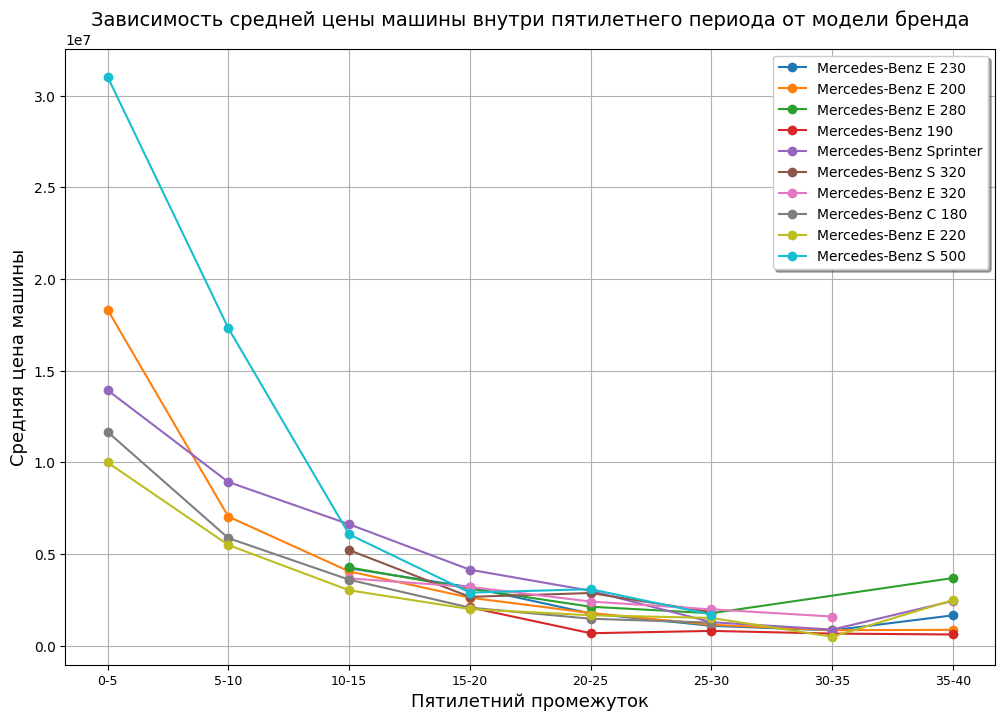

In [212]:
car_dct = {'Mercedes-Benz': ['E 230','E 200', 'E 280', '190', 'Sprinter', 'S 320', 'E 320', 'C 180', 'E 220', 'S 500']}
check_value_deprecatin_by_brand_and_models(df1, car_dct)

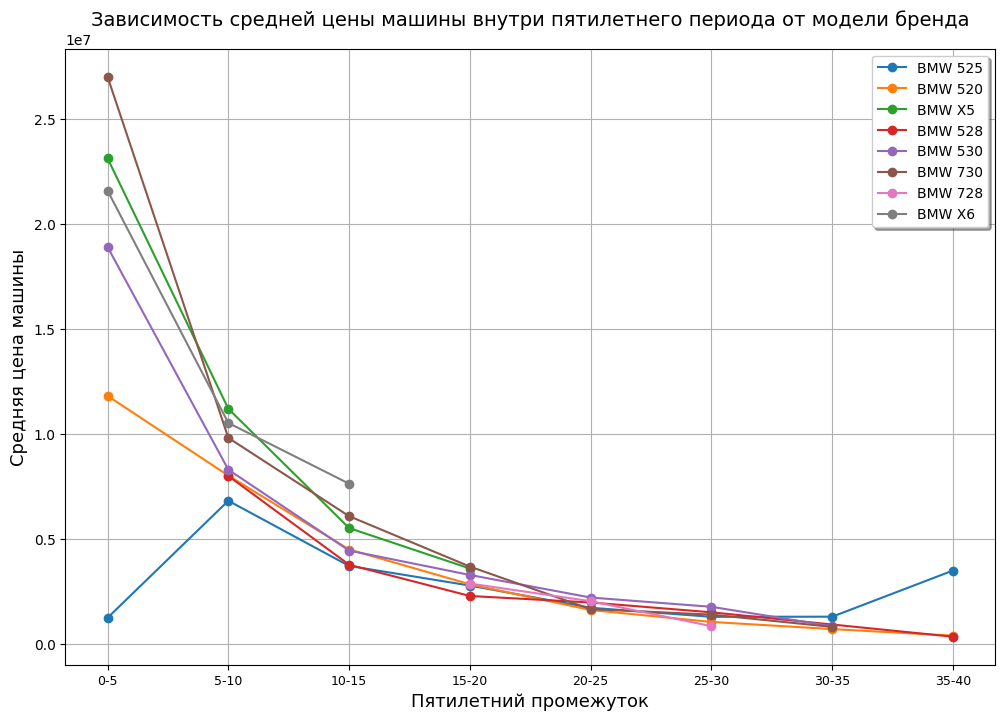

In [207]:
car_dct = {'BMW': ['525', '520', 'X5', '528', '530', '730', '728', 'X6']}
check_value_deprecatin_by_brand_and_models(df1, car_dct)

В среднем все бренды и модели подвержены обесцениванию. Тренд обесценения можно назвать экспоненциально убывающим. Машины теряют большую часть своей стоимости в первые 5 лет.

Однако после 35 лет, некоторые модели машин начинают расти в стоимости - видимо это связано с тем, что они переходят в категорию раритетов.

# Результат исследования

- Построены __модели линейной регрессии__: обычная, Lasso, Ridge
- Построена модель __градиентного бустинга__ на функциях потерь __RMSE__ и __MAE__
- В исследовании использовались метрики __RMSE, MAE, MAPE, $R^2$__
- __Лучшей оказалась модель бустинга, обученного на функции потерь MAE__ с использованием текстового описания машины. Метрика __MAE__ на тестовой выборке оказалась равна __0.20479__ (Для сравнения константная модель выдает MAE равную 0.809 на тесте, Ridge регрессия с регуляризацией 0.222, а бустинг без текстовых данных 0.20819).
- Самым важным признаком для модели с точки зрения shap values с большим оказался __возраст машины__. На втором и третем месте по важности находятся бренд машины и объем двигателя.
- Был проведен анализ обесценивания машин со временем. Из построенных графиков видно, что в среднем __машины теряют половину своей стоимости в первые 5 лет__, а далее их цена монотонно убывает. Однако некоторые модели машин начинают расти в стоимости после 35 лет. Возможно, это связано с тем, что они переходят в категорию раритетных машин.
- Тренд обесценения машин со временем можно назвать __экспоненциально убывающим__



#  Что еще можно сделать для увеличения точности прогноза (что я не успел сделать)

- Перебор гиперпараметров в бустинге
- tf-idf + pca + бустинг - возможно такой пайплайн даст прирост в качестве
- Выделение новых фичей из датасета (как с переменной retro)
- Предсказание обесценения машины со врмененем - нужно составлять датасет для этой задаче на основе текущего датасета